###### Татур А.А.
###### ver 0.1
###### 17.10.2022

Цели:

1. Проверить размер изображений. Если 256*256, то сохранить в папку для обработки. Если отличается, то изменить размер.
2. Создать функцию для различных аугментаций (вращение, растяжение....), которые принимают изображение, по рандомным параметрам его преобразуют, сохраняют в новый файл.
3. Запустить преобразование. На входе изображение 256х256, рандомный выбор функции аугментации, передача изображения в функцию преобразования

##### Импорт модулей

In [326]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import shutil
import random
from __future__ import print_function
import pickle
import os.path
import io
import requests
import zipfile
from mimetypes import MimeTypes
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload

#### Выполняем загрузку из GoogleDrive (честно стырено с https://www.geeksforgeeks.org/upload-and-download-files-from-google-drive-storage-using-python/).

In [327]:
class DriveAPI:
    global SCOPES
    SCOPES = ['https://www.googleapis.com/auth/drive']
    def __init__(self):
        
        self.creds = None
  
        if os.path.exists('token.pickle'):
  
            with open('token.pickle', 'rb') as token:
                self.creds = pickle.load(token)
  
        if not self.creds or not self.creds.valid:
  
            if self.creds and self.creds.expired and self.creds.refresh_token:
                self.creds.refresh(Request())
            else:
                flow = InstalledAppFlow.from_client_secrets_file(
                    'credentials.json', SCOPES)
                self.creds = flow.run_local_server(port=0)
  
            with open('token.pickle', 'wb') as token:
                pickle.dump(self.creds, token)
  
        self.service = build('drive', 'v3', credentials=self.creds)
  
        results = self.service.files().list(
            pageSize=100, fields="files(id, name)").execute()
        items = results.get('files', [])
  
  
    def FileDownload(self, file_id, file_name):
        request = self.service.files().get_media(fileId=file_id)
        fh = io.BytesIO()
        #204800
        downloader = MediaIoBaseDownload(fh, request, chunksize=8388608)
        done = False
  
        try:
            while not done:
                print ("Downloading in progress")
                status, done = downloader.next_chunk()
                print (status)
             
            fh.seek(0)
              
            with open(file_name, 'wb') as f:
                shutil.copyfileobj(fh, f)
  
            print("File Downloaded")
            return True
        except:
            
            print("Something went wrong.")
            return False


##### Загружаем файлы

In [328]:
obj = DriveAPI()

f_id = '1IEa-ZgmqmdAWMu50KoEqoeHnks0-RTDt'
f_name = 'source_autos.zip'
obj.FileDownload(f_id, f_name)


f_id = '1OPROwaqb7cw6PwmFFaK7cm57Etx-ji-_'
f_name = 'source_woautos.zip'
obj.FileDownload(f_id, f_name)

File Downloaded
File Downloaded


True

###### Разархивируем скачанные архивы

In [330]:
print ('Startin to unzip file source_autos.zip')
ziped_source_autos = zipfile.ZipFile('source_autos.zip')
ziped_source_autos.extractall('source_autos')
ziped_source_autos.close()
print ('Finished\n')

print ('Startin to unzip file source_woautos.zip')
ziped_source_woautos = zipfile.ZipFile('source_woautos.zip')
ziped_source_woautos.extractall('source_woautos')
ziped_source_woautos.close()
print ('Finished\n')

Startin to unzip file source_autos.zip
Finished

Startin to unzip file source_woautos.zip
Finished



#### Если загрузка не сработала, то скачиваем файлы по ссылке из гугл драйв и извлекаем в корень в папки source_autos и source_woautos

In [240]:
#try: 
#    os.mkdir('source_autos')
#except FileExistsError:
#    shutil.rmtree ('source_autos')
#    os.mkdir ('source_autos')

#try: 
#    os.mkdir('source_woautos')
#except FileExistsError:
#    shutil.rmtree ('source_woautos')
#    os.mkdir ('source_woautos')


###### https://drive.google.com/file/d/1DjNcQVy8wfsx-Kw2iAwQr_e_DlGIN5Hx/view?usp=sharing
###### Разархивировать в каталог с программой.

##### Функция изменения размера с исходного на 256*256 всех изображений в папке

In [331]:
def resize(directory,outputdir):
    '''
    directory - название папки, где лежат исходные изображения
    outputdir - папка, куда будут сложены измененные изображения
    '''
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory,filename))
        if (img.shape[0:2])!=(256,256):
            img=cv2.resize(img,(256,256), interpolation=cv2.INTER_AREA)
        new_name=filename[:-4]+'_resized.jpg'
        path_to_save=os.path.join(outputdir,new_name)
        cv2.imwrite(path_to_save, img)
    

#### Меняем размеры всех файлов в каталогах source

In [332]:
##### Создаем директории. Если они созданы, то удаляем и создаем новые.

try: 
    os.mkdir('resized_autos')
except FileExistsError:
    shutil.rmtree ('resized_autos')
    os.mkdir ('resized_autos')

try: 
    os.mkdir('resized_woautos')
except FileExistsError:
    shutil.rmtree ('resized_woautos')
    os.mkdir ('resized_woautos')

    
##### Запускаем функцию по изменению размеров изображений

resize('source_autos','resized_autos')
resize('source_woautos','resized_woautos')

##### Функция трансформации изображения

In [333]:
def reshape(file_name, angle=0, scale=1,z1=0.00000,z2=0.00000,z3=1):
    '''
    Функция для изменения изображения
    file_name - имя файла
    angle=0 - угол поворота
    scale=1 - увеличение
    z1=0.00000 - вращение относительно оси OY
    z2=0.00000 - вращение относительно оси OX
    z3=1 - приближение
    '''
       
    img = cv2.imread(file_name)
    w=img.shape[1]
    h=img.shape[0]
    center=(w//2,h//2)
    Matrix=cv2.getRotationMatrix2D(center,angle,scale)
    New_Matrix=np.append(Matrix,np.array([z1,z2,z3])).reshape(3,3)
    return (cv2.warpPerspective(img, New_Matrix, (w,h)))

##### Функция для чтения изображений и сохранения трансформированных.

In [334]:
def random_reshape(directory,outputdir,n_transf):
    '''
    directory - название папки, где лежат исходные изображения
    outputdir - папка, куда будут сложены измененные изображения
    n_transf - количество аугментаций для каждого файла
    '''
    for filename in os.listdir(directory):
        for i in range (n_transf):
            reshaped = reshape(os.path.join(directory,filename), random.randint(0,180), 1,
                              random.randint(1, 9)/1000, random.randint(1, 9)/1000, random.randint(0,10)/10)
            new_name=str(filename[0:-4]) + '_reshaped_' + str(i) + '_' + '.jpg'
            path_to_save=os.path.join(outputdir,new_name)
            cv2.imwrite(path_to_save, reshaped)

#### Трансформируем все изображения в каталогах resized

In [335]:
##### Создаем директории. Если они созданы, то удаляем и создаем новые.
    
try: 
    os.mkdir('reshaped_autos')
except FileExistsError:
    shutil.rmtree ('reshaped_autos')
    os.mkdir ('reshaped_autos')
    
try: 
    os.mkdir('reshaped_woautos')
except FileExistsError:
    shutil.rmtree ('reshaped_woautos')
    os.mkdir ('reshaped_woautos')

##### Запускаем функцию по изменению параметров изображений    

random_reshape ('resized_autos','reshaped_autos',3)
random_reshape ('resized_woautos','reshaped_woautos',3)

##### Пример выполнения

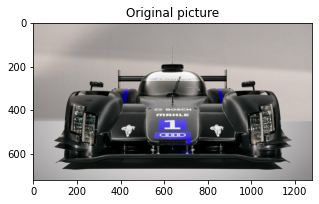

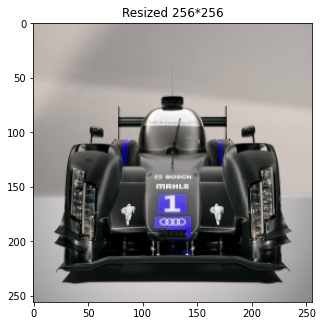

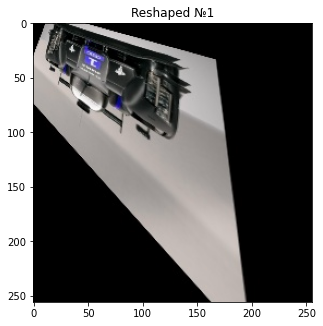

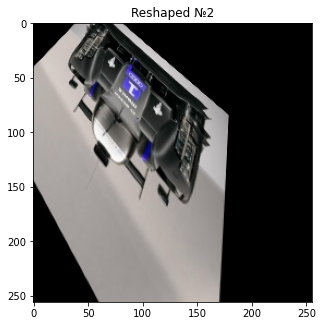

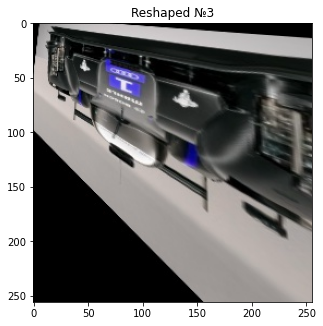

In [336]:
img1 = cv2.imread('source_autos/1.jpg')
img2 = cv2.imread('resized_autos/1_resized.jpg')
img3 = cv2.imread('reshaped_autos/1_resized_reshaped_0_.jpg')
img4 = cv2.imread('reshaped_autos/1_resized_reshaped_1_.jpg')
img5 = cv2.imread('reshaped_autos/1_resized_reshaped_2_.jpg')

plt.figure (figsize=(5,10))
plt.title ("Original picture")
plt.imshow(img1)

plt.figure (figsize=(5,10))
plt.title ("Resized 256*256")
plt.imshow(img2)

plt.figure (figsize=(5,10))
plt.title ("Reshaped №1")
plt.imshow(img3)

plt.figure (figsize=(5,10))
plt.title ("Reshaped №2")
plt.imshow(img4)

plt.figure (figsize=(5,10))
plt.title ("Reshaped №3")
plt.imshow(img5)